In [24]:
# MODIFY! 
# use RobustScaler! 
model_name = 'RandFo'

# Import Libraries & Data 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('./data/dl-pfe-ns.csv')
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [27]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [28]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

## Determine Max Features

In [29]:
# MODIFY!
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(warm_start=True)
model

RandomForestRegressor(warm_start=True)

In [30]:
p_grid = {
    'max_features':['auto', 'sqrt', 'log2']
}

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
grid_model = GridSearchCV(
    estimator=model,
    param_grid =p_grid, 
    scoring='neg_mean_squared_error',
    cv=10, 
    verbose=1
)

In [33]:
grid_model.fit(X_train,y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   24.5s finished


GridSearchCV(cv=10, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2']},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
grid_model.best_params_

{'max_features': 'auto'}

In [35]:
hp = pd.Series(name=f'{model_name} HP', data=grid_model.best_params_)

In [36]:
hp

max_features    auto
Name: RandFo HP, dtype: object

In [48]:
hp.to_csv(f'./hyperparameters/{model_name}-hp.csv')

## Determine Number of Estimators

In [65]:
# MODIFY!
import time

estimators = [5,10,25,50,100,500,1000,2000]
scores_list = []

from sklearn.ensemble import RandomForestRegressor

for e in estimators: 
    start = time.time()
    print(f'Starting {e} estimators')
    score_model = RandomForestRegressor(
        n_estimators=e,
        max_features=grid_model.best_params_['max_features']
    )
    
    from sklearn.model_selection import cross_validate

    scores = cross_validate(
        score_model, 
        X_train, 
        y_train,
        scoring=[
            'neg_mean_absolute_error',
            'neg_mean_squared_error',
            'neg_root_mean_squared_error'
        ],
        cv=10
    )
    
    scores = pd.DataFrame(scores)
    scores
    mean_scores = scores.mean()
    scores_list.append(mean_scores)
    print(f'Done with {e} estimators')
    end = time.time()
    print(f'Elapsed time: {end - start}')
    print('\n')

Starting 5 estimators
Done with 5 estimators
Elapsed time: 1.1068732738494873


Starting 10 estimators
Done with 10 estimators
Elapsed time: 2.0407936573028564


Starting 25 estimators
Done with 25 estimators
Elapsed time: 4.767342805862427


Starting 50 estimators
Done with 50 estimators
Elapsed time: 30.217728853225708


Starting 100 estimators
Done with 100 estimators
Elapsed time: 24.62099289894104


Starting 500 estimators
Done with 500 estimators
Elapsed time: 104.31003093719482


Starting 1000 estimators
Done with 1000 estimators
Elapsed time: 224.5287570953369


Starting 2000 estimators
Done with 2000 estimators
Elapsed time: 429.16848707199097




In [70]:
scores_df = pd.DataFrame(scores_list)

In [71]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.105702,0.003816,-3.307852,-20.037608,-4.467688
1,0.199591,0.003161,-3.176469,-18.412284,-4.283099
2,0.470657,0.004836,-3.070383,-17.326094,-4.152791
3,2.978185,0.037266,-3.011804,-16.773294,-4.084647
4,2.440067,0.019049,-3.014882,-16.715898,-4.078936
5,10.322474,0.097420,-3.007980,-16.596149,-4.064413
6,22.168896,0.254339,-3.006173,-16.635206,-4.068881
7,42.244145,0.616773,-3.007373,-16.650553,-4.071124


In [72]:
scores_df['Est'] = estimators

In [73]:
scores_df

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error,Est
0,0.105702,0.003816,-3.307852,-20.037608,-4.467688,5
1,0.199591,0.003161,-3.176469,-18.412284,-4.283099,10
2,0.470657,0.004836,-3.070383,-17.326094,-4.152791,25
3,2.978185,0.037266,-3.011804,-16.773294,-4.084647,50
4,2.440067,0.019049,-3.014882,-16.715898,-4.078936,100
5,10.322474,0.097420,-3.007980,-16.596149,-4.064413,500
6,22.168896,0.254339,-3.006173,-16.635206,-4.068881,1000
7,42.244145,0.616773,-3.007373,-16.650553,-4.071124,2000


# Export Scores for Number of Estimators

In [74]:
# mean_scores

In [75]:
scores_df = scores_df.rename(columns={
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [76]:
scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.105702,0.003816,-3.307852,-20.037608,-4.467688,5
1,0.199591,0.003161,-3.176469,-18.412284,-4.283099,10
2,0.470657,0.004836,-3.070383,-17.326094,-4.152791,25
3,2.978185,0.037266,-3.011804,-16.773294,-4.084647,50
4,2.440067,0.019049,-3.014882,-16.715898,-4.078936,100
5,10.322474,0.097420,-3.007980,-16.596149,-4.064413,500
6,22.168896,0.254339,-3.006173,-16.635206,-4.068881,1000
7,42.244145,0.616773,-3.007373,-16.650553,-4.071124,2000


In [77]:
scores_df[['MAE','MSE','RMSE']] = scores_df[['MAE','MSE','RMSE']].apply(lambda x : abs(x))

In [78]:
scores_df
# we go for 25 estimations. Note that from 25 -> 50 estimations the error metrics worsen

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,0.105702,0.003816,3.307852,20.037608,4.467688,5
1,0.199591,0.003161,3.176469,18.412284,4.283099,10
2,0.470657,0.004836,3.070383,17.326094,4.152791,25
3,2.978185,0.037266,3.011804,16.773294,4.084647,50
4,2.440067,0.019049,3.014882,16.715898,4.078936,100
5,10.322474,0.097420,3.007980,16.596149,4.064413,500
6,22.168896,0.254339,3.006173,16.635206,4.068881,1000
7,42.244145,0.616773,3.007373,16.650553,4.071124,2000


In [79]:
scores_df.to_csv(f'./scores/{model_name}-score.csv')

In [80]:
pct_scores_df = scores_df.pct_change()

In [81]:
pct_scores_df

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.888241,-0.171776,-0.039719,-0.081114,-0.041316,1.0
2,1.358105,0.530113,-0.033397,-0.058993,-0.030424,1.5
3,5.327715,6.705774,-0.019079,-0.031906,-0.016409,1.0
4,-0.180687,-0.488856,0.001022,-0.003422,-0.001398,1.0
5,3.230407,4.114311,-0.002289,-0.007164,-0.003560,4.0
6,1.147634,1.610741,-0.000601,0.002353,0.001099,1.0
7,0.905559,1.425003,0.000399,0.000923,0.000551,1.0


In [82]:
pct_scores_df.style.background_gradient() 
# we choose index 4, 100 Estimations <- 
    # Score time decrease 3->4 & Score time increase dramatically 4->5
    # unsubstantial decrease MSE & RMSE 4->5 compared to 3->4

,Fit Time,Score Time,MAE,MSE,RMSE,Est
0,nan,nan,nan,nan,nan,nan
1,0.888241,-0.171776,-0.039719,-0.081114,-0.041316,1.000000
2,1.358105,0.530113,-0.033397,-0.058993,-0.030424,1.500000
3,5.327715,6.705774,-0.019079,-0.031906,-0.016409,1.000000
4,-0.180687,-0.488856,0.001022,-0.003422,-0.001398,1.000000
5,3.230407,4.114311,-0.002289,-0.007164,-0.003560,4.000000
6,1.147634,1.610741,-0.000601,0.002353,0.001099,1.000000
7,0.905559,1.425003,0.000399,0.000923,0.000551,1.000000


# Score Model

In [83]:
# MODIFY!
# adopt number of estimators from the previous section

score_model = RandomForestRegressor(n_estimators=100)
score_model

RandomForestRegressor()

In [84]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [85]:
scores = pd.DataFrame(scores)

In [86]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,2.005647,0.018748,-3.004957,-16.826831,-4.102052
1,1.717539,0.013996,-2.832815,-15.695460,-3.961750
2,1.782674,0.012811,-3.285017,-19.782330,-4.447733
3,1.634927,0.012576,-3.057435,-18.672452,-4.321163
4,1.704660,0.016080,-2.859191,-15.148121,-3.892059
5,1.855059,0.013109,-3.265831,-17.850563,-4.224993
6,1.673420,0.013997,-3.306442,-20.277385,-4.503042
7,1.687890,0.022493,-2.945883,-15.243690,-3.904317
8,1.697661,0.015497,-2.839027,-14.313607,-3.783333
9,1.722747,0.015404,-2.746463,-13.960770,-3.736411


In [87]:
mean_scores = scores.mean()

In [88]:
mean_scores

fit_time                             1.748222
score_time                           0.015471
test_neg_mean_absolute_error        -3.014306
test_neg_mean_squared_error        -16.777121
test_neg_root_mean_squared_error    -4.087685
dtype: float64

# Export Scores

In [89]:
mean_scores = mean_scores.rename(f'{model_name}')

In [90]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [91]:
# mean_scores

In [92]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [93]:
mean_scores

Fit Time       1.748222
Score Time     0.015471
MAE            3.014306
MSE           16.777121
RMSE           4.087685
Name: RandFo, dtype: float64

In [94]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [95]:
mean_scores

Fit Time       1.748222
Score Time     0.015471
MAE            3.014306
MSE           16.777121
RMSE           4.087685
STD FT         0.109028
STD ST         0.003088
STD MAE        0.207628
STD MSE        2.265832
STD RMSE       0.274774
Name: RandFo, dtype: float64

In [96]:
mean_scores.to_csv(f'./scores/{model_name}-100-score.csv')

# Holdout Test

In [97]:
score_model.fit(X_train,y_train)

RandomForestRegressor()

In [98]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

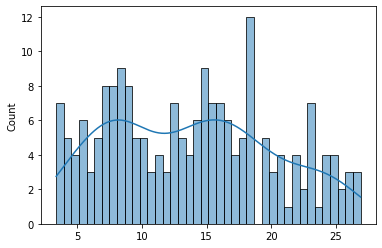

In [99]:
sns.histplot(y_holdout,bins=40,kde=True)

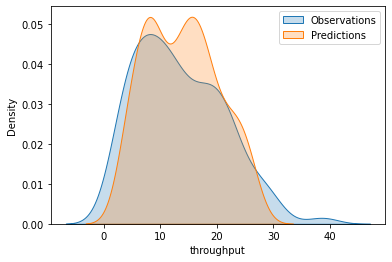

In [100]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

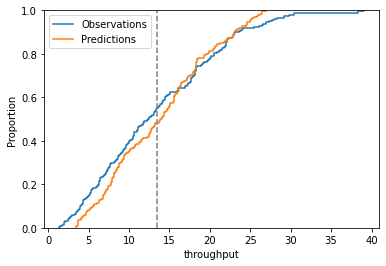

In [101]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [102]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [103]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFo
MAE,3.004429
MSE,17.242662
RMSE,4.152428


In [104]:
err_df.to_csv(f'./holdout-test/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [105]:
res = y_test - y_holdout
res.describe().drop('count')

mean    -0.375198
std      4.145926
min    -13.515220
25%     -2.491491
50%     -0.546028
75%      1.931068
max     14.984834
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

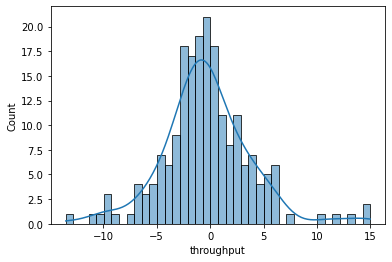

In [106]:
sns.histplot(data=res, kde=True,bins=40)

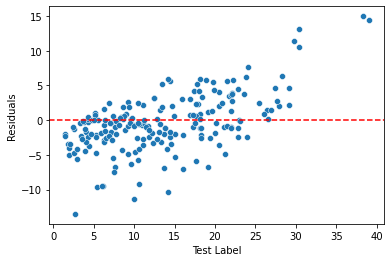

In [107]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

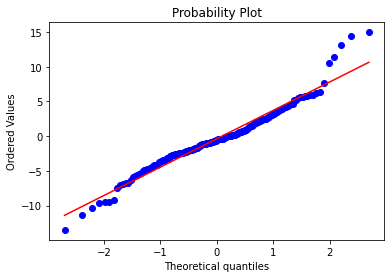

In [108]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [109]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [110]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

RandomForestRegressor()

In [111]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

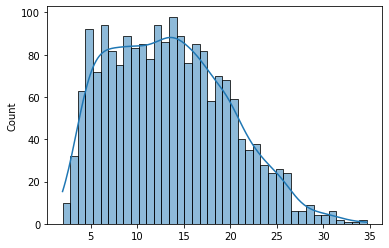

In [112]:
sns.histplot(y_pred,bins=40,kde=True)

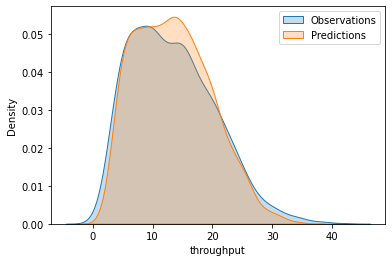

In [113]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

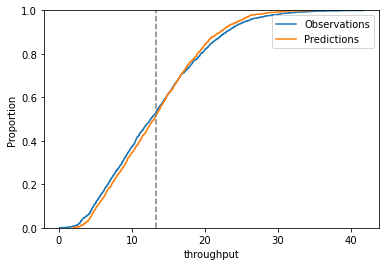

In [114]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [115]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [116]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,RandFo
MAE,1.123234
MSE,2.360329
RMSE,1.536336


In [117]:
err_df.to_csv(f'./model-err/{model_name}-err.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [118]:
from joblib import dump, load
dump(op_model, f'./opt-models/{model_name}-model.joblib')

['./opt-models/RandFo-model.joblib']

In [119]:
res = y - y_pred
res.describe().drop('count')

mean   -0.038916
std     1.536232
min    -6.658851
25%    -0.894703
50%    -0.106979
75%     0.696700
max     7.751977
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

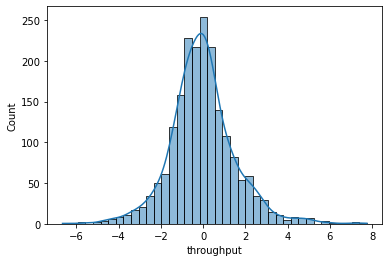

In [120]:
sns.histplot(data=res, kde=True,bins=40)

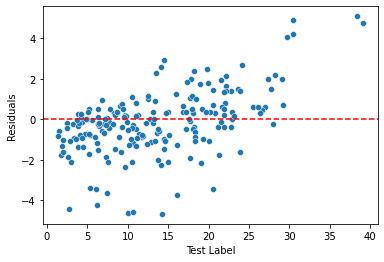

In [121]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

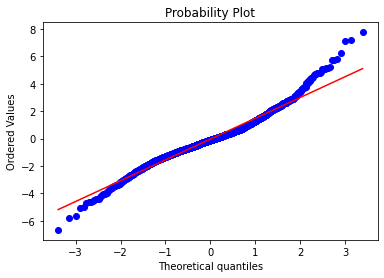

In [122]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE!